# Bionformatics and Network Medicine Project

## 1. PPI and GDA data gathering and interactome reconstruction

In [1]:
#import libraries
import pandas as pd
import networkx as nx
import scipy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import KFold
import os
import itertools
import pprint
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import hypergeom
import markov_clustering as mc
from collections import deque
from matplotlib.image import imread
from IPython.display import display, HTML

### 1.1 Download PPIs

In [2]:
#ppi network
biogrid = pd.read_csv('BIOGRID.txt', sep = '\t', header = 0, low_memory = False)

In [3]:
biogrid

,#BioGRID Interaction ID,Entrez Gene Interactor A,Entrez Gene Interactor B,BioGRID ID Interactor A,BioGRID ID Interactor B,Systematic Name Interactor A,Systematic Name Interactor B,Official Symbol Interactor A,Official Symbol Interactor B,Synonyms Interactor A,...,TREMBL Accessions Interactor B,REFSEQ Accessions Interactor B,Ontology Term IDs,Ontology Term Names,Ontology Term Categories,Ontology Term Qualifier IDs,Ontology Term Qualifier Names,Ontology Term Types,Organism Name Interactor A,Organism Name Interactor B
0,103,6416,2318,112315,108607,-,-,MAP2K4,FLNC,JNKK|JNKK1|MAPKK4|MEK4|MKK4|PRKMK4|SAPKK-1|SAP...,...,Q59H94,NP_001120959|NP_001449,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1,117,84665,88,124185,106603,-,-,MYPN,ACTN2,CMD1DD|CMH22|MYOP|RCM4,...,Q59FD9|F6THM6,NP_001094|NP_001265272|NP_001265273,-,-,-,-,-,-,Homo sapiens,Homo sapiens
2,183,90,2339,106605,108625,-,-,ACVR1,FNTA,ACTRI|ACVR1A|ACVRLK2|ALK2|FOP|SKR1|TSRI,...,-,NP_002018,-,-,-,-,-,-,Homo sapiens,Homo sapiens
3,278,2624,5371,108894,111384,-,-,GATA2,PML,DCML|IMD21|MONOMAC|NFE1B,...,-,NP_150250|NP_150253|NP_150252|NP_150247|NP_150...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
4,418,6118,6774,112038,112651,RP4-547C9.3,-,RPA2,STAT3,REPA2|RP-A p32|RP-A p34|RPA32,...,-,NP_644805|NP_003141|NP_001356447|NP_001356443|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1188614,3590145,253260,7408,128962,113251,-,-,RICTOR,VASP,AVO3|PIA|hAVO3,...,A0A024R0V4,NP_003361,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1188615,3590146,253260,1072,128962,107499,-,-,RICTOR,CFL1,AVO3|PIA|hAVO3,...,V9HWI5,NP_005498,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1188616,3590147,7189,4217,113041,110381,-,RP3-325F22.4,TRAF6,MAP3K5,MGC:3310|RNF85,...,-,NP_005914,-,-,-,-,-,-,Homo sapiens,Homo sapiens
1188617,3621586,8237,1956,113866,108276,RP4-659F15.2,-,USP11,EGFR,UHX1,...,-,NP_001333829|NP_001333828|NP_958440|NP_005219|...,-,-,-,-,-,-,Homo sapiens,Homo sapiens


In [4]:
biogrid.shape

(1188619, 37)

In [5]:
biogrid.columns

Index(['#BioGRID Interaction ID', 'Entrez Gene Interactor A',
       'Entrez Gene Interactor B', 'BioGRID ID Interactor A',
       'BioGRID ID Interactor B', 'Systematic Name Interactor A',
       'Systematic Name Interactor B', 'Official Symbol Interactor A',
       'Official Symbol Interactor B', 'Synonyms Interactor A',
       'Synonyms Interactor B', 'Experimental System',
       'Experimental System Type', 'Author', 'Publication Source',
       'Organism ID Interactor A', 'Organism ID Interactor B', 'Throughput',
       'Score', 'Modification', 'Qualifications', 'Tags', 'Source Database',
       'SWISS-PROT Accessions Interactor A', 'TREMBL Accessions Interactor A',
       'REFSEQ Accessions Interactor A', 'SWISS-PROT Accessions Interactor B',
       'TREMBL Accessions Interactor B', 'REFSEQ Accessions Interactor B',
       'Ontology Term IDs', 'Ontology Term Names', 'Ontology Term Categories',
       'Ontology Term Qualifier IDs', 'Ontology Term Qualifier Names',
       'Ontology

In [6]:
#take only the subset in which the organism has 9606 as code
biogrid = biogrid[(biogrid['Organism ID Interactor A']==9606) & (biogrid['Organism ID Interactor B']==9606) ]

In [7]:
#select the experimental type
biogrid = biogrid[biogrid['Experimental System Type']=='physical']

In [8]:
#take only the two columns of interest to build the network
ppi = biogrid[['Official Symbol Interactor A', 'Official Symbol Interactor B']]

In [9]:
ppi

,Official Symbol Interactor A,Official Symbol Interactor B
0,MAP2K4,FLNC
1,MYPN,ACTN2
2,ACVR1,FNTA
3,GATA2,PML
4,RPA2,STAT3
...,...,...
1188614,RICTOR,VASP
1188615,RICTOR,CFL1
1188616,TRAF6,MAP3K5
1188617,USP11,EGFR


In [10]:
ppi.shape

(1085794, 2)

In [11]:
#check the shape of the dataframe without duplicates (it will not remove rows with the same genes but in different columns)
ppi.drop_duplicates().shape

(863825, 2)

In [12]:
bio = nx.from_pandas_edgelist(ppi,
                              source = "Official Symbol Interactor A",
                              target = "Official Symbol Interactor B",
                             create_using=nx.Graph())      # nx.Graph() doesn't allow duplicated edges
print(bio) #the nr of edges is lower than the nr of dataframe rows because of the non extracted duplicates

Graph with 19821 nodes and 813171 edges


In [13]:
#identify and remove self loops
self_loops_bio = list(nx.selfloop_edges(bio))
print("Number of self loops: ", len(self_loops_bio))
bio.remove_edges_from(self_loops_bio)
print(bio)

Number of self loops:  3228
Graph with 19821 nodes and 809943 edges


In [14]:
#isolate the largest connected component (LCC)
components = list(nx.connected_components(bio))
largest_component = max(components, key = len)
LCC_bio = bio.subgraph(largest_component)

In [15]:
print(LCC_bio)

Graph with 19816 nodes and 809943 edges


### 1.2 Gather gene-disease associations (GDAs)

In [16]:
disease = pd.read_csv('DISEASE.tsv', sep='\t')

In [17]:
disease

,Disease,Disease_id,Gene,Gene_id,UniProt,Gene_Full_Name,Protein_Class,N_diseases_g,DSI_g,DPI_g,pLI,Score_gda,EL_gda,EI_gda,N_PMIDs,N_SNPs_gda,First_Ref,Last_Ref
0,"Alveolitis, Fibrosing",C4721507,CXCL8,3576,P10145,C-X-C motif chemokine ligand 8,Signaling,109,0.310,0.962,2.737700e-04,0.32,NaN,1.0,2,0,1995,2007
1,"Alveolitis, Fibrosing",C4721507,FN1,2335,P02751,fibronectin 1,Signaling,44,0.365,0.962,1.404500e-03,0.31,NaN,1.0,1,0,1999,2016
2,"Alveolitis, Fibrosing",C4721507,SERPINA1,5265,P01009,serpin family A member 1,Enzyme modulator,59,0.410,0.923,6.849700e-08,0.31,NaN,1.0,1,0,1977,1977
3,"Alveolitis, Fibrosing",C4721507,IL1RN,3557,P18510,interleukin 1 receptor antagonist,NaN,92,0.373,0.923,3.091400e-02,0.31,NaN,1.0,1,0,2000,2008
4,"Alveolitis, Fibrosing",C4721507,TNF,7124,P01375,tumor necrosis factor,Signaling,340,0.231,0.962,8.033000e-01,0.31,NaN,1.0,5,0,2000,2014
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,"Alveolitis, Fibrosing",C4721507,HGF,3082,P14210,hepatocyte growth factor,Enzyme,73,0.374,0.885,9.994700e-01,0.30,NaN,1.0,1,0,2006,2006
79,"Alveolitis, Fibrosing",C4721507,CXCL2,2920,P19875,C-X-C motif chemokine ligand 2,Signaling,44,0.513,0.885,3.607900e-07,0.30,NaN,1.0,1,0,2006,2006
80,"Alveolitis, Fibrosing",C4721507,GREM1,26585,O60565,"gremlin 1, DAN family BMP antagonist",NaN,13,0.508,0.808,4.743600e-01,0.30,NaN,1.0,1,0,2008,2008
81,"Alveolitis, Fibrosing",C4721507,FYN,2534,P06241,"FYN proto-oncogene, Src family tyrosine kinase",Kinase,17,0.556,0.731,9.940600e-01,0.30,NaN,1.0,1,0,2019,2019


In [18]:
disease_genes = list(disease['Gene']) #identify the set of disease genes

In [19]:
#create a subgraph of disease genes
disease_network = LCC_bio.subgraph(disease_genes).copy()

In [20]:
print("Number of nodes:", disease_network.number_of_nodes())

Number of nodes: 77


In [21]:
print("Number of edges:", disease_network.number_of_edges())

Number of edges: 52


### 1.3 Compute and characterize the disease LCC and its basic network measures

In [22]:
#isolate the disease LCC and remove self loops
lcc_comp = list(nx.connected_components(disease_network))
lcc_disease = max(lcc_comp, key=len)
LCC_disease = disease_network.subgraph(lcc_disease).copy()

self_loops_disease = list(nx.selfloop_edges(LCC_disease))
print("Number of self loops: ", len(self_loops_disease))
LCC_disease.remove_edges_from(self_loops_disease)

print("Number of nodes in LCC: ", LCC_disease.number_of_nodes())
print("Number of edges in LCC: ", LCC_disease.number_of_edges())

Number of self loops:  0
Number of nodes in LCC:  41
Number of edges in LCC:  52


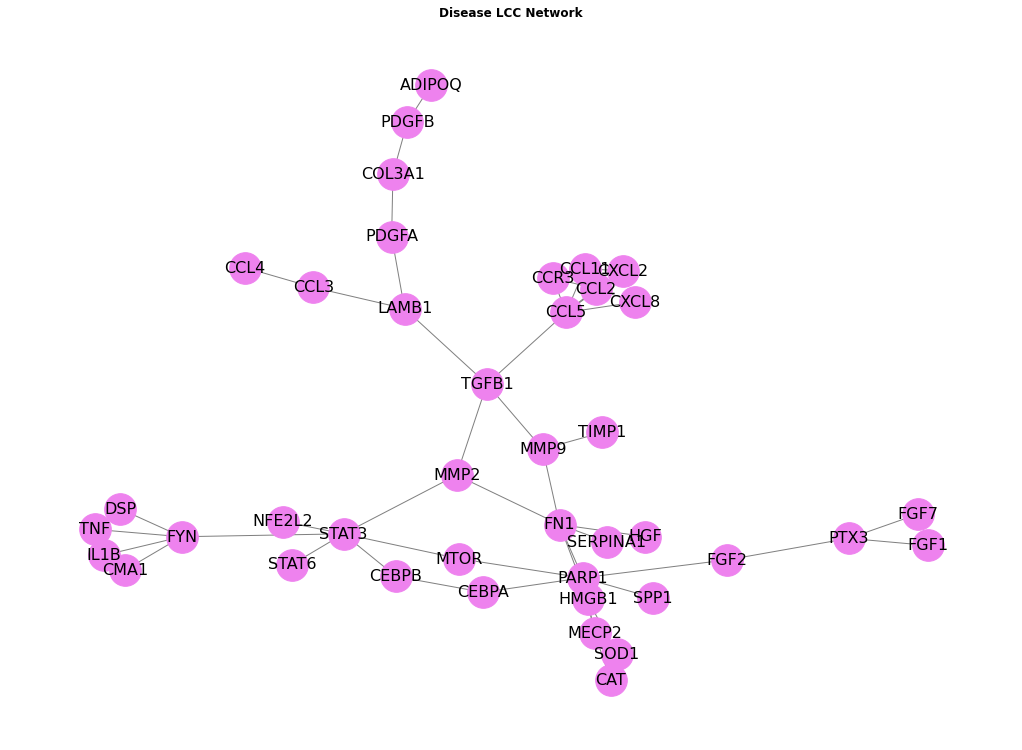

In [23]:
#plot the disease LCC 
pos = nx.spring_layout(LCC_disease, seed=42)  


plt.figure(figsize=(14, 10))  
nx.draw(LCC_disease, pos, with_labels=True, node_color='violet', node_size=1000, 
        edge_color='gray', linewidths=1, font_size=16)

plt.title("Disease LCC Network", fontweight='bold')
plt.show()

In [24]:
#function to visualize metrics taken from the NetworkX Lab
def print_dict(string, dictionary, n = 5):
    """
    Utility function to display only the first n elements
    of a dictionary.
    """
    dictionary = dict(dictionary)

    out = dict(itertools.islice(dictionary.items(), n))
    print(string)
    print("-" * len(string))
    pprint.pprint(out)
    print("")
nodes = LCC_disease.nodes()
gene_measures = dict(nodes)
print_dict("Gene measures dictionary:", gene_measures)

Gene measures dictionary:
-------------------------
{'ADIPOQ': {}, 'PDGFB': {}, 'SOD1': {}, 'STAT3': {}, 'TNF': {}}



In [25]:
#compute required metrics
degree = LCC_disease.degree()
bet = nx.betweenness_centrality(LCC_disease)
clos = nx.closeness_centrality(LCC_disease)

In [26]:
try:
    eigen = nx.eigenvector_centrality(LCC_disease, max_iter=500, tol=1e-04)
except nx.PowerIterationFailedConvergence as e:
    print(f"Failed to converge: {e}")

In [27]:
degree_dict = dict(degree)
ratio = {}

for node in LCC_disease.nodes():
    if degree_dict[node] > 0:
        ratio[node] = bet[node] / degree_dict[node]
    else:
        ratio[node] = 0

In [28]:
#insert metrics in the dictionary
for gene in gene_measures:
    gene_measures[gene]["Degree"] = degree[gene]
    gene_measures[gene]["Betweeness"] = bet[gene]
    gene_measures[gene]["Closeness"] = clos[gene]
    gene_measures[gene]["Eigen"] = eigen[gene]
    gene_measures[gene]["BetoverDeg"] = ratio[gene]
print_dict("Gene measures:", gene_measures)

Gene measures:
--------------
{'ADIPOQ': {'BetoverDeg': 0.0,
            'Betweeness': 0.0,
            'Closeness': 0.13559322033898305,
            'Degree': 1,
            'Eigen': 0.0004607770579722482},
 'PDGFB': {'BetoverDeg': 0.025,
           'Betweeness': 0.05,
           'Closeness': 0.15625,
           'Degree': 2,
           'Eigen': 0.001710651740720863},
 'SOD1': {'BetoverDeg': 0.004594017094017097,
          'Betweeness': 0.009188034188034194,
          'Closeness': 0.21739130434782608,
          'Degree': 2,
          'Eigen': 0.03816335567318415},
 'STAT3': {'BetoverDeg': 0.060042735042735045,
           'Betweeness': 0.36025641025641025,
           'Closeness': 0.31746031746031744,
           'Degree': 6,
           'Eigen': 0.07734374232254387},
 'TNF': {'BetoverDeg': 0.0,
         'Betweeness': 0.0,
         'Closeness': 0.20408163265306123,
         'Degree': 1,
         'Eigen': 0.00862343136339998}}



In [29]:
#build a metrics dataframe
measures_disease = pd.DataFrame.from_dict(gene_measures, orient ='index')
measures_disease = measures_disease.reset_index()
measures_disease.rename(columns={'index': 'Gene'}, inplace=True)

In [30]:
measures_disease

,Gene,Degree,Betweeness,Closeness,Eigen,BetoverDeg
0,ADIPOQ,1,0.000000,0.135593,0.000461,0.000000
1,PDGFB,2,0.050000,0.156250,0.001711,0.025000
2,SOD1,2,0.009188,0.217391,0.038163,0.004594
3,TNF,1,0.000000,0.204082,0.008623,0.000000
4,STAT3,6,0.360256,0.317460,0.077344,0.060043
5,FGF7,1,0.000000,0.167364,0.003590,0.000000
6,HGF,1,0.000000,0.246914,0.040861,0.000000
7,CCR3,3,0.000000,0.210526,0.355656,0.000000
8,MTOR,2,0.092308,0.287770,0.059221,0.046154
9,NFE2L2,1,0.000000,0.242424,0.020883,0.000000


In [31]:
#measures_disease = pd.read_csv('measures_disease.csv')
len(measures_disease)

41

In [32]:
#sort and adjust the output 
sorted_metrics = measures_disease.sort_values(by='Degree', ascending=False)

In [33]:
sorted_metrics.reset_index(inplace=True)

In [34]:
sorted_metrics.drop('index', axis=1)

,Gene,Degree,Betweeness,Closeness,Eigen,BetoverDeg
0,PARP1,7,0.326496,0.303030,0.141850,0.046642
1,CCL5,6,0.228205,0.261438,0.505746,0.038034
2,STAT3,6,0.360256,0.317460,0.077344,0.060043
3,FN1,6,0.357906,0.325203,0.151309,0.059651
4,FYN,5,0.191026,0.254777,0.031927,0.038205
5,TGFB1,4,0.516239,0.322581,0.215820,0.129060
6,HMGB1,4,0.077991,0.272109,0.110197,0.019498
7,CCL11,4,0.001282,0.211640,0.407804,0.000321
8,CCL2,4,0.001282,0.211640,0.407804,0.000321
9,MECP2,3,0.039530,0.239521,0.076501,0.013177


In [35]:
#add a ranking column
sorted_metrics['Ranking'] = sorted_metrics.index + 1

In [36]:
column_order = ['Ranking'] + [col for col in sorted_metrics.columns if col != 'Ranking']
sorted_metrics = sorted_metrics[column_order]
sorted_metrics.drop('index', axis=1, inplace=True)

In [37]:
sorted_metrics.set_index('Ranking', inplace=True)

In [38]:
html_table = sorted_metrics.to_html(border=0)
display(HTML(html_table))

,Gene,Degree,Betweeness,Closeness,Eigen,BetoverDeg
Ranking,,,,,,
1,PARP1,7,0.326496,0.303030,0.141850,0.046642
2,CCL5,6,0.228205,0.261438,0.505746,0.038034
3,STAT3,6,0.360256,0.317460,0.077344,0.060043
4,FN1,6,0.357906,0.325203,0.151309,0.059651
5,FYN,5,0.191026,0.254777,0.031927,0.038205
6,TGFB1,4,0.516239,0.322581,0.215820,0.129060
7,HMGB1,4,0.077991,0.272109,0.110197,0.019498
8,CCL11,4,0.001282,0.211640,0.407804,0.000321
9,CCL2,4,0.001282,0.211640,0.407804,0.000321


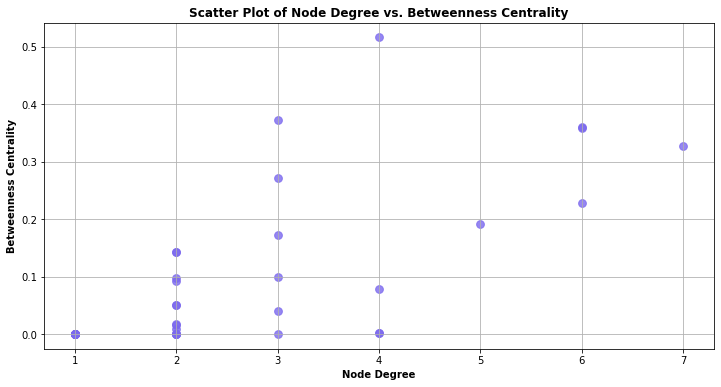

In [39]:
#scatterplot of degree vs betweeness
x = measures_disease['Degree']
y = measures_disease['Betweeness']


plt.figure(figsize=(12, 6))
plt.scatter(x, y, color='mediumslateblue', alpha=0.8, s=60)


plt.title('Scatter Plot of Node Degree vs. Betweenness Centrality', fontweight='bold')
plt.xlabel('Node Degree', fontweight='bold')
plt.ylabel('Betweenness Centrality', fontweight='bold')
plt.grid()

plt.show()

In [40]:
disease_table = disease[['Disease', 'Disease_id']]

In [41]:
disease_table = disease_table.iloc[0:1]

In [42]:
disease_table = disease_table.rename(columns =({'Disease': 'Disease name', 'Disease_id': 'UMLS disease ID'}))

In [43]:
disease_table['MeSH disease class'] = 'D011658'
disease_table['Number of associated genes'] = len(disease)
disease_table['Number of genes present in the interactome'] = disease_network.number_of_nodes()
disease_table['LCC size of the disease interactome'] = LCC_disease.number_of_nodes()

In [44]:
disease_table.set_index('Disease name')

,UMLS disease ID,MeSH disease class,Number of associated genes,Number of genes present in the interactome,LCC size of the disease interactome
Disease name,,,,,
"Alveolitis, Fibrosing",C4721507,D011658,83,77,41


## 2. Comparative analysis of the disease genes identification algorithms

### 2.1 Prepare the set up to run algorithms

In [45]:
#ppi network edgelist
nx.write_edgelist(LCC_bio, "bio.txt", data=False, delimiter='\t')

In [46]:
#lcc disease edgelist -> seed genes
with open("seeds.txt", "w") as file:
    for node in disease_network.nodes():
        file.write(f"{node}\n")

In [47]:
isolated_nodes = list(nx.isolates(disease_network))
number_of_isolated_nodes = len(isolated_nodes)
print(f"Number of isolated nodes: {number_of_isolated_nodes}")

Number of isolated nodes: 36


In [48]:
seed_genes = set()
with open("seeds.txt", "r") as file:
    for line in file:
        edge = line.strip().split()
        seed_genes.update(edge)

In [49]:
seed_genes_list = list(seed_genes)
print("Number of seed genes: ", len(seed_genes_list), "\n")
print("Seed genes list: ", seed_genes_list, end = ' ')

Number of seed genes:  77 

Seed genes list:  ['ABCA3', 'IL4', 'ADIPOQ', 'PDGFB', 'SOD3', 'CCR2', 'SOD1', 'GREM1', 'TGFA', 'TNF', 'STAT3', 'FGF7', 'MIR30A', 'FAM13A', 'HGF', 'EGF', 'CSF2', 'IGF1', 'CCR3', 'MTOR', 'NFE2L2', 'MMP9', 'CCL4', 'MIR122', 'MECP2', 'SKIL', 'ELN', 'CAT', 'MIR29C', 'IL1RN', 'FGF2', 'CEBPA', 'CCL2', 'PTX3', 'IL1B', 'HMOX1', 'CMA1', 'CCL3', 'AGT', 'LAMB1', 'IL6', 'CSF3', 'MIR326', 'STAT6', 'FN1', 'IL13', 'MMP2', 'TIMP1', 'SPP1', 'PDGFA', 'CALCA', 'CCL11', 'HMGB1', 'COL3A1', 'CXCL8', 'FYN', 'AREG', 'MIR26B', 'MIR378A', 'CEBPB', 'BMP7', 'EDN1', 'DSP', 'IL5', 'CFD', 'SERPINA1', 'TGFB1', 'CYSLTR2', 'IL12B', 'CXCL2', 'MIR140', 'ACTA2', 'PARP1', 'SMAD7', 'FGF1', 'CCL5', 'MIR200C'] 

In [ ]:
# 5-fold Cross Validation to create train and probe sets
# run only one time for reproducibility

'''
kf = KFold(n_splits=5, shuffle=True, random_state=42)
folds = list(kf.split(seed_genes_list))

for i, (train_index, test_index) in enumerate(folds):
    
    train_set = {seed_genes_list[index] for index in train_index}
    probe_set = {seed_genes_list[index] for index in test_index}
    probe_set_file = f"probe_set_fold_{i+1}.txt"
    with open(probe_set_file, "w") as file:
        for gene in probe_set:
            file.write(f"{gene}\n")

    train_set_file = f"train_set_fold_{i+1}.txt"
    with open(train_set_file, "w") as file:
        for gene in train_set:
            file.write(f"{gene}\n")         
'''

### 2.2 DIAMOnD

In [50]:
diamond_precisions, diamond_recalls, diamond_f1_scores = [], [], []

for n_fold in range(1,6):
    probe_set_file = f"probe_sets/probe_set_fold_{n_fold}.txt"
    with open(probe_set_file, "r") as file:
        probe_set = [line.strip() for line in file]
        print(f"Probe Set fold {n_fold}: ", probe_set)
        
    train_set_file = f"train_sets/train_set_fold_{n_fold}.txt"
    
    get_ipython().run_line_magic('run', f'algorithms/DIAMOnD.py bio.txt {train_set_file} 100 output_DIAMOnD/output_file_fold_{n_fold}_DIAMOnD.txt')
    
    diamond_output_file = f"output_DIAMOnD/output_file_fold_{n_fold}_DIAMOnD.txt"
    with open(diamond_output_file, "r") as file:
        diamond_output = [line.strip().split()[1] for line in file if line.strip() and not line.startswith('#')]
    
    true_positives = set(diamond_output).intersection(probe_set)
    
    print(f"True positives fold {n_fold}: ", true_positives)
    print("----------------------------------------------------")
    print(" ")

    precision = len(true_positives) / len(diamond_output) if diamond_output else 0
    recall = len(true_positives) / len(probe_set) if probe_set else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0
    
    diamond_precisions.append(precision)
    diamond_recalls.append(recall)
    diamond_f1_scores.append(f1)

overall_avg_diamond_precision = np.mean(diamond_precisions)
overall_sd_diamond_precision = np.std(diamond_precisions)

overall_avg_diamond_recall = np.mean(diamond_recalls)
overall_sd_diamond_recall = np.std(diamond_recalls)

overall_avg_diamond_f1 = np.mean(diamond_f1_scores)
overall_sd_diamond_f1 = np.std(diamond_f1_scores)

print(f"Overall Precision (average ± SD) using DIAMOnD: {overall_avg_diamond_precision:.4f} ± {overall_sd_diamond_precision:.4f}")
print(f"Overall Recall (average ± SD) using DIAMOnD: {overall_avg_diamond_recall:.4f} ± {overall_sd_diamond_recall:.4f}")
print(f"Overall F1-Score (average ± SD) using DIAMOnD: {overall_avg_diamond_f1:.4f} ± {overall_sd_diamond_f1:.4f}")


Probe Set fold 1:  ['CCL11', 'IL13', 'SKIL', 'CALCA', 'MIR200C', 'CCL2', 'SOD1', 'SPP1', 'ACTA2', 'MMP9', 'FGF7', 'CCL3', 'MMP2', 'IL5', 'DSP', 'MTOR']

 results have been saved to 'output_DIAMOnD/output_file_fold_1_DIAMOnD.txt' 

True positives fold 1:  {'CCL11', 'MMP2', 'CCL2', 'MMP9'}
----------------------------------------------------
 
Probe Set fold 2:  ['CYSLTR2', 'NFE2L2', 'EDN1', 'TGFA', 'AREG', 'SMAD7', 'MIR378A', 'TIMP1', 'PDGFB', 'CEBPB', 'IL12B', 'SERPINA1', 'TGFB1', 'CXCL2', 'ABCA3', 'CCL5']

 results have been saved to 'output_DIAMOnD/output_file_fold_2_DIAMOnD.txt' 

True positives fold 2:  {'PDGFB', 'CCL5', 'CXCL2'}
----------------------------------------------------
 
Probe Set fold 3:  ['CAT', 'CFD', 'IGF1', 'FGF1', 'CMA1', 'CSF2', 'CXCL8', 'MIR140', 'IL1B', 'PTX3', 'TNF', 'EGF', 'ADIPOQ', 'GREM1', 'IL6']

 results have been saved to 'output_DIAMOnD/output_file_fold_3_DIAMOnD.txt' 

True positives fold 3:  {'CXCL8', 'ADIPOQ'}
---------------------------------------

#### DIAMOnD Cutoff metrics

In [51]:
n = disease_network.number_of_nodes()
sizes = [n // 10, n // 4, n // 2, 50, n] 
cutoffs = [int(0.1 * n), int(0.25 * n), int(0.5 * n), 50, n]
metrics_diamond = {size: {'precision': [], 'recall': [], 'f1': []} for size in sizes}

for n_fold in range(1,6):
    probe_set_file = f"probe_sets/probe_set_fold_{n_fold}.txt"
    with open(probe_set_file, "r") as file:
        probe_set = [line.strip() for line in file]
            
    diamond_output_file = f"output_DIAMOnD/output_file_fold_{n_fold}_DIAMOnD.txt"
    with open(diamond_output_file, "r") as file:
        diamond_output = [line.strip().split()[1] for line in file if line.strip() and not line.startswith('#')]

    for i, size in enumerate(sizes):
            cutoff = cutoffs[i]
            selected_genes = set(diamond_output[:cutoff])
            
            true_positives = selected_genes.intersection(probe_set)

            precision = len(true_positives) / len(selected_genes) if selected_genes else 0
            recall = len(true_positives) / len(probe_set) if probe_set else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

            metrics_diamond[size]['precision'].append(precision)
            metrics_diamond[size]['recall'].append(recall)
            metrics_diamond[size]['f1'].append(f1)

for size in sizes:
    avg_diamond_precision = np.mean(metrics_diamond[size]['precision'])
    sd_diamond_precision = np.std(metrics_diamond[size]['precision'])
    
    avg_diamond_recall = np.mean(metrics_diamond[size]['recall'])
    sd_diamond_recall = np.std(metrics_diamond[size]['recall'])
    
    avg_diamond_f1 = np.mean(metrics_diamond[size]['f1'])
    sd_diamond_f1 = np.std(metrics_diamond[size]['f1'])
    
    print(f"Top_{size} - Precision (average ± SD) using DIAMOnD: {avg_diamond_precision:.4f} ± {sd_diamond_precision:.4f}")
    print(f"Top_{size} - Recall (average ± SD) using DIAMOnD: {avg_diamond_recall:.4f} ± {sd_diamond_recall:.4f}")
    print(f"Top_{size} - F1-Score (average ± SD) using DIAMOnD: {avg_diamond_f1:.4f} ± {sd_diamond_f1:.4f}")
    print("")

Top_7 - Precision (average ± SD) using DIAMOnD: 0.0571 ± 0.0700
Top_7 - Recall (average ± SD) using DIAMOnD: 0.0250 ± 0.0306
Top_7 - F1-Score (average ± SD) using DIAMOnD: 0.0348 ± 0.0426

Top_19 - Precision (average ± SD) using DIAMOnD: 0.0421 ± 0.0516
Top_19 - Recall (average ± SD) using DIAMOnD: 0.0500 ± 0.0612
Top_19 - F1-Score (average ± SD) using DIAMOnD: 0.0457 ± 0.0560

Top_38 - Precision (average ± SD) using DIAMOnD: 0.0421 ± 0.0357
Top_38 - Recall (average ± SD) using DIAMOnD: 0.1017 ± 0.0841
Top_38 - F1-Score (average ± SD) using DIAMOnD: 0.0595 ± 0.0501

Top_50 - Precision (average ± SD) using DIAMOnD: 0.0320 ± 0.0271
Top_50 - Recall (average ± SD) using DIAMOnD: 0.1017 ± 0.0841
Top_50 - F1-Score (average ± SD) using DIAMOnD: 0.0487 ± 0.0410

Top_77 - Precision (average ± SD) using DIAMOnD: 0.0312 ± 0.0176
Top_77 - Recall (average ± SD) using DIAMOnD: 0.1542 ± 0.0856
Top_77 - F1-Score (average ± SD) using DIAMOnD: 0.0518 ± 0.0292



In [52]:
def plot_all_metrics(metrics_dict, sizes, metric_colors, algo):
    plt.figure(figsize=(10, 6))
    bar_width = 0.25
    r1 = np.arange(len(sizes))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    for metric_name, color in metric_colors.items():
        averages = [np.mean(metrics_dict[size][metric_name]) for size in sizes]
        std_devs = [np.std(metrics_dict[size][metric_name]) for size in sizes]

        if metric_name == 'precision':
            plt.errorbar(r1, averages, yerr=std_devs, fmt='o', color=color, label=metric_name, capsize=7, alpha=0.7)
        elif metric_name == 'recall':
            plt.errorbar(r2, averages, yerr=std_devs, fmt='o', color=color, label=metric_name, capsize=7, alpha=0.7)
        else:
            plt.errorbar(r3, averages, yerr=std_devs, fmt='o', color=color, label=metric_name, capsize=7, alpha=0.7)

    plt.xticks([r + bar_width for r in range(len(sizes))], [f"Top {size}" for size in sizes])
    plt.ylabel('Metric Values', fontweight='bold')
    plt.xlabel('Cutoff Sizes', fontweight='bold')
    plt.title('Comparison of Precision, Recall, and F1-Score Across Different Cutoffs using '+ algo, fontweight='bold')
    plt.legend()
    plt.tight_layout()
    plt.grid()
    plt.show()

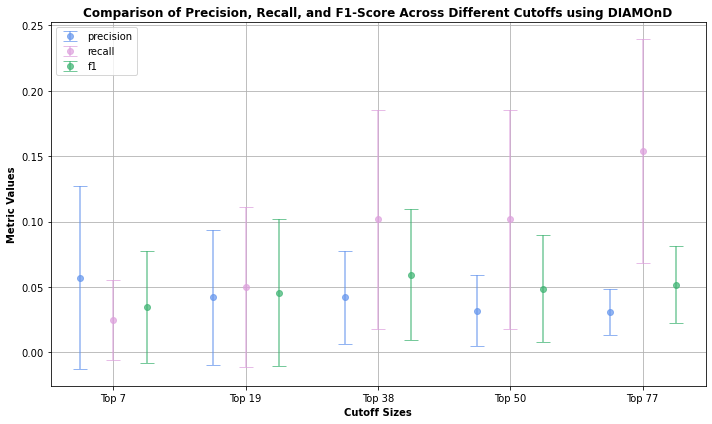

In [53]:
metric_colors = {'precision': 'cornflowerblue', 'recall': (221/255, 160/255, 221/255, 0.8), 'f1': 'mediumseagreen'}  
plot_all_metrics(metrics_diamond, sizes, metric_colors, 'DIAMOnD')

### 2.3 DiaBLE

In [54]:
diable_precisions, diable_recalls, diable_f1_scores = [], [], []

for n_fold in range(1,6):
    probe_set_file = f"probe_sets/probe_set_fold_{n_fold}.txt"
    with open(probe_set_file, "r") as file:
        probe_set = [line.strip() for line in file]
        print(f"Probe Set fold {n_fold}: ", probe_set)
        
    train_set_file = f"train_sets/train_set_fold_{n_fold}.txt"

    get_ipython().run_line_magic('run', f'algorithms/DiaBLE.py bio.txt {train_set_file} 100 output_DiaBLE/output_file_fold_{n_fold}_DiaBLE.txt')
    
    diable_output_file = f"output_DiaBLE/output_file_fold_{n_fold}_DiaBLE.txt"
    with open(diable_output_file, "r") as file:
        diable_output = [line.strip().split()[1] for line in file if line.strip() and not line.startswith('#')]
        
    true_positives = set(diable_output).intersection(probe_set)
    print(f"True positives fold {n_fold}: ", true_positives)
    print("----------------------------------------------------")
    print(" ")

    precision = len(true_positives) / len(diable_output) if diable_output else 0
    recall = len(true_positives) / len(probe_set) if probe_set else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    diable_precisions.append(precision)
    diable_recalls.append(recall)
    diable_f1_scores.append(f1)

overall_avg_diable_precision = np.mean(diable_precisions)
overall_sd_diable_precision = np.std(diable_precisions)

overall_avg_diable_recall = np.mean(diable_recalls)
overall_sd_diable_recall = np.std(diable_recalls)

overall_avg_diable_f1 = np.mean(diable_f1_scores)
overall_sd_diable_f1 = np.std(diable_f1_scores)

print(f"Overall Precision (average ± SD) using DiaBLE: {overall_avg_diable_precision:.4f} ± {overall_sd_diable_precision:.4f}")
print(f"Overall Recall (average ± SD) using DiaBLE: {overall_avg_diable_recall:.4f} ± {overall_sd_diable_recall:.4f}")
print(f"Overall F1-Score (average ± SD) using DiaBLE: {overall_avg_diable_f1:.4f} ± {overall_sd_diable_f1:.4f}")

Probe Set fold 1:  ['CCL11', 'IL13', 'SKIL', 'CALCA', 'MIR200C', 'CCL2', 'SOD1', 'SPP1', 'ACTA2', 'MMP9', 'FGF7', 'CCL3', 'MMP2', 'IL5', 'DSP', 'MTOR']

 results have been saved to 'output_DiaBLE/output_file_fold_1_DiaBLE.txt' 

True positives fold 1:  {'CCL11', 'MMP2', 'CCL2', 'MMP9'}
----------------------------------------------------
 
Probe Set fold 2:  ['CYSLTR2', 'NFE2L2', 'EDN1', 'TGFA', 'AREG', 'SMAD7', 'MIR378A', 'TIMP1', 'PDGFB', 'CEBPB', 'IL12B', 'SERPINA1', 'TGFB1', 'CXCL2', 'ABCA3', 'CCL5']

 results have been saved to 'output_DiaBLE/output_file_fold_2_DiaBLE.txt' 

True positives fold 2:  {'PDGFB', 'CCL5', 'CXCL2'}
----------------------------------------------------
 
Probe Set fold 3:  ['CAT', 'CFD', 'IGF1', 'FGF1', 'CMA1', 'CSF2', 'CXCL8', 'MIR140', 'IL1B', 'PTX3', 'TNF', 'EGF', 'ADIPOQ', 'GREM1', 'IL6']

 results have been saved to 'output_DiaBLE/output_file_fold_3_DiaBLE.txt' 

True positives fold 3:  {'CXCL8', 'ADIPOQ'}
---------------------------------------------

#### DiaBLE Cutoff metrics

In [55]:
n = disease_network.number_of_nodes()
sizes = [n // 10, n // 4, n // 2, 50, n] 
cutoffs = [int(0.1 * n), int(0.25 * n), int(0.5 * n), 50, n]
metrics_diable = {size: {'precision': [], 'recall': [], 'f1': []} for size in sizes}

for n_fold in range(1,6):
    probe_set_file = f"probe_sets/probe_set_fold_{n_fold}.txt"
    with open(probe_set_file, "r") as file:
        probe_set = [line.strip() for line in file]
            
    diable_output_file = f"output_DiaBLE/output_file_fold_{n_fold}_DiaBLE.txt"
    with open(diable_output_file, "r") as file:
        diable_output = [line.strip().split()[1] for line in file if line.strip() and not line.startswith('#')]

    for i, size in enumerate(sizes):
            cutoff = cutoffs[i]
            selected_genes = set(diable_output[:cutoff])
            
            true_positives = set(selected_genes).intersection(probe_set)

            precision = len(true_positives) / len(selected_genes) if selected_genes else 0
            recall = len(true_positives) / len(probe_set) if probe_set else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

            metrics_diable[size]['precision'].append(precision)
            metrics_diable[size]['recall'].append(recall)
            metrics_diable[size]['f1'].append(f1)

for size in sizes:
    avg_diable_precision = np.mean(metrics_diable[size]['precision'])
    sd_diable_precision = np.std(metrics_diable[size]['precision'])
    
    avg_diable_recall = np.mean(metrics_diable[size]['recall'])
    sd_diable_recall = np.std(metrics_diable[size]['recall'])
    
    avg_diable_f1 = np.mean(metrics_diable[size]['f1'])
    sd_diable_f1 = np.std(metrics_diable[size]['f1'])
    
    print(f"Top_{size} - Precision (average ± SD) using DiaBLE: {avg_diable_precision:.4f} ± {sd_diable_precision:.4f}")
    print(f"Top_{size} - Recall (average ± SD) using DiaBLE: {avg_diable_recall:.4f} ± {sd_diable_recall:.4f}")
    print(f"Top_{size} - F1-Score (average ± SD) using DiaBLE: {avg_diable_f1:.4f} ± {sd_diable_f1:.4f}")
    print("")

Top_7 - Precision (average ± SD) using DiaBLE: 0.0571 ± 0.0700
Top_7 - Recall (average ± SD) using DiaBLE: 0.0250 ± 0.0306
Top_7 - F1-Score (average ± SD) using DiaBLE: 0.0348 ± 0.0426

Top_19 - Precision (average ± SD) using DiaBLE: 0.0421 ± 0.0516
Top_19 - Recall (average ± SD) using DiaBLE: 0.0500 ± 0.0612
Top_19 - F1-Score (average ± SD) using DiaBLE: 0.0457 ± 0.0560

Top_38 - Precision (average ± SD) using DiaBLE: 0.0368 ± 0.0268
Top_38 - Recall (average ± SD) using DiaBLE: 0.0892 ± 0.0631
Top_38 - F1-Score (average ± SD) using DiaBLE: 0.0521 ± 0.0377

Top_50 - Precision (average ± SD) using DiaBLE: 0.0320 ± 0.0271
Top_50 - Recall (average ± SD) using DiaBLE: 0.1017 ± 0.0841
Top_50 - F1-Score (average ± SD) using DiaBLE: 0.0487 ± 0.0410

Top_77 - Precision (average ± SD) using DiaBLE: 0.0312 ± 0.0176
Top_77 - Recall (average ± SD) using DiaBLE: 0.1542 ± 0.0856
Top_77 - F1-Score (average ± SD) using DiaBLE: 0.0518 ± 0.0292



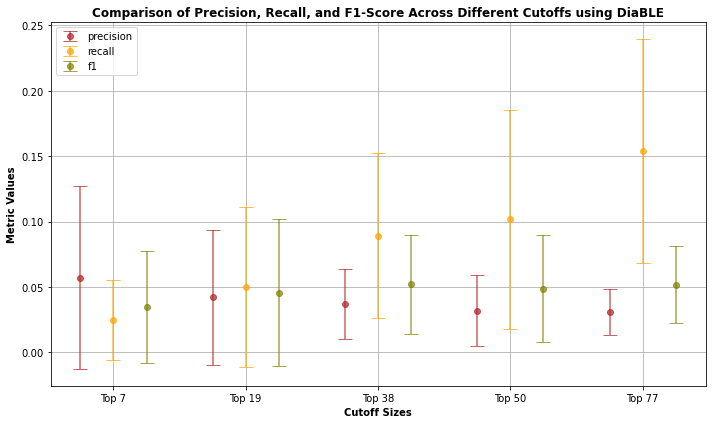

In [56]:
metric_colors = {'precision': 'firebrick', 'recall': 'orange', 'f1': 'olive'}  
plot_all_metrics(metrics_diable, sizes, metric_colors, 'DiaBLE')

### 2.4 Comparison between DIAMOnD and DiaBLE

#### Eccentricity

In [57]:
eccentricity = nx.eccentricity(LCC_bio, v = list(seed_genes_list))
print("Seed Genes Eccentricity: ", dict(eccentricity), end = ' ')

Seed Genes Eccentricity:  {'ABCA3': 5, 'IL4': 5, 'ADIPOQ': 5, 'PDGFB': 5, 'SOD3': 5, 'CCR2': 5, 'SOD1': 4, 'GREM1': 5, 'TGFA': 5, 'TNF': 4, 'STAT3': 4, 'FGF7': 5, 'MIR30A': 5, 'FAM13A': 5, 'HGF': 5, 'EGF': 5, 'CSF2': 5, 'IGF1': 5, 'CCR3': 5, 'MTOR': 4, 'NFE2L2': 4, 'MMP9': 5, 'CCL4': 5, 'MIR122': 5, 'MECP2': 4, 'SKIL': 5, 'ELN': 5, 'CAT': 4, 'MIR29C': 5, 'IL1RN': 5, 'FGF2': 5, 'CEBPA': 4, 'CCL2': 5, 'PTX3': 5, 'IL1B': 5, 'HMOX1': 5, 'CMA1': 5, 'CCL3': 5, 'AGT': 5, 'LAMB1': 4, 'IL6': 5, 'CSF3': 5, 'MIR326': 5, 'STAT6': 5, 'FN1': 4, 'IL13': 5, 'MMP2': 5, 'TIMP1': 5, 'SPP1': 5, 'PDGFA': 5, 'CALCA': 5, 'CCL11': 5, 'HMGB1': 4, 'COL3A1': 5, 'CXCL8': 5, 'FYN': 4, 'AREG': 5, 'MIR26B': 5, 'MIR378A': 5, 'CEBPB': 4, 'BMP7': 5, 'EDN1': 5, 'DSP': 4, 'IL5': 5, 'CFD': 5, 'SERPINA1': 5, 'TGFB1': 4, 'CYSLTR2': 5, 'IL12B': 6, 'CXCL2': 5, 'MIR140': 5, 'ACTA2': 5, 'PARP1': 4, 'SMAD7': 4, 'FGF1': 5, 'CCL5': 5, 'MIR200C': 5} 

The eccentricy of a node in the graph is the maximum distance between a vertex to all other vertices. An eccentricity of 4-5 for a node suggets a form of centrality in the graph, indicating that the node can easily reach other nodes within a limitated number of steps.

#### Distance-based considerations

In [58]:
def count_nodes_at_distance_grater_than_2(G, seed_genes):
    # standard BFS visit starting from seed genes
    visited = set()
    queue = deque([(node, 0) for node in seed_genes]) 
    count = 0

    while queue:
        current_node, distance = queue.popleft()

        if current_node not in visited:
            visited.add(current_node)
            
            # increment the counter if the distance is greater than 2
            if distance > 2:
                count += 1

            for neighbor in G[current_node]:
                if neighbor not in visited:
                    queue.append((neighbor, distance + 1))

    return count

In [59]:
result = count_nodes_at_distance_grater_than_2(LCC_bio, seed_genes_list)
print("Number of nodes at a distance greater than 2 starting from the seed genes list: ", result)

Number of nodes at a distance greater than 2 starting from the seed genes list:  484


In conclusion, it is reasonable to observe that DIAMOnD and DiaBLE have demonstrated similar performances. The optimization introduced by the DiaBLE algorithm appears to have a limited impact on our network, because the majority of nodes are located within a distance equal to or less than 2 (first and second-degree neighbors). Consequently, from the initial iterations, DIAMOnD and DiaBLE exhibit very similar universe sizes and overall algorithmic performance remains consistent.

### 2.5 Diffusion 

#### t=0.002

In [60]:
diffusion2 = pd.read_csv('output_diffusion/T2.csv')
diffusion2 = diffusion2.rename(columns={'diffusion_output_rank':'diffusion_output_0_rank'})
diffusion2

,diffusion_input,diffusion_output_1_heat,diffusion_output_1_rank,diffusion_output_2_heat,diffusion_output_2_rank,diffusion_output_3_heat,diffusion_output_3_rank,diffusion_output_4_heat,diffusion_output_4_rank,diffusion_output_heat,diffusion_output_0_rank,name,selected,shared name
0,0.0,8.077851e-11,19815,8.666073e-11,19815,8.253924e-11,19815,7.053725e-11,19814,7.688210e-11,19814,OR2T12,False,OR2T12
1,0.0,8.481006e-09,19788,7.309082e-09,19792,7.600094e-09,19790,5.441425e-09,19792,5.818827e-09,19789,POTEH,False,POTEH
2,0.0,1.727962e-08,19761,1.803408e-08,19761,1.741298e-08,19761,7.191839e-09,19788,1.332982e-08,19773,SPDYE3,False,SPDYE3
3,0.0,5.789610e-09,19795,1.858008e-06,19041,1.857957e-06,19030,1.857137e-06,18703,1.853326e-06,18871,VNN3,False,VNN3
4,0.0,1.385752e-06,19179,1.379635e-06,19210,1.403664e-06,19202,3.560332e-07,19241,1.323554e-06,19107,LOC100996747,False,LOC100996747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19811,0.0,5.799460e-05,9876,6.665888e-05,9580,6.655396e-05,9377,5.457155e-05,9351,5.985734e-05,9348,MAP3K8,False,MAP3K8
19812,0.0,1.419724e-04,6682,1.395738e-04,6957,1.388596e-04,6790,7.575762e-05,8003,1.205392e-04,6650,MAP4K2,False,MAP4K2
19813,0.0,4.079855e-03,352,5.527422e-03,182,4.418003e-03,279,3.974398e-03,315,4.274831e-03,258,MAPK8,False,MAPK8
19814,0.0,4.482629e-04,4617,4.722864e-04,4627,4.634346e-04,4613,3.465606e-04,3768,3.893133e-04,4253,SPAG9,False,SPAG9


In [61]:
precisions, recalls, f1_scores = [], [], []
top_n = 100

for i in range(5):
    column_name = f'diffusion_output_{i}_rank'  
    all_genes = diffusion2.sort_values(by=column_name)['name'].to_list()
    train_set_file = f'train_sets/train_set_fold_{i+1}.txt'
    with open(train_set_file, 'r') as file:
        train_set = {line.strip() for line in file}

    top_genes = [gene for gene in all_genes if gene not in train_set][:top_n]

    probe_set_file = f'probe_sets/probe_set_fold_{i+1}.txt'  
    with open(probe_set_file, 'r') as file:
        probe_set = {line.strip() for line in file}
    print(f"Probe Set fold {i+1}: ", probe_set)
        
    true_positives = set(top_genes).intersection(probe_set)
    print(f"True positives fold {i+1}: ", true_positives)
    print(" ")

    precision = len(true_positives) / len(top_genes) if top_genes else 0
    recall = len(true_positives) / len(probe_set) if probe_set else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0    

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

Probe Set fold 1:  {'ACTA2', 'IL13', 'CALCA', 'MTOR', 'CCL11', 'MMP2', 'CCL2', 'FGF7', 'DSP', 'IL5', 'SKIL', 'MIR200C', 'SOD1', 'MMP9', 'SPP1', 'CCL3'}
True positives fold 1:  {'CCL11', 'CCL2'}
 
Probe Set fold 2:  {'TGFB1', 'AREG', 'ABCA3', 'SMAD7', 'TGFA', 'TIMP1', 'EDN1', 'PDGFB', 'CXCL2', 'NFE2L2', 'IL12B', 'MIR378A', 'CCL5', 'SERPINA1', 'CEBPB', 'CYSLTR2'}
True positives fold 2:  {'CCL5'}
 
Probe Set fold 3:  {'CXCL8', 'MIR140', 'IL6', 'TNF', 'GREM1', 'CAT', 'ADIPOQ', 'FGF1', 'PTX3', 'IL1B', 'CFD', 'EGF', 'CSF2', 'CMA1', 'IGF1'}
True positives fold 3:  set()
 
Probe Set fold 4:  {'PDGFA', 'BMP7', 'CCR3', 'AGT', 'LAMB1', 'ELN', 'STAT3', 'MIR326', 'MIR122', 'MIR29C', 'HMOX1', 'FAM13A', 'HGF', 'CCL4', 'COL3A1'}
True positives fold 4:  {'STAT3', 'CCR3'}
 
Probe Set fold 5:  {'CSF3', 'IL1RN', 'PARP1', 'IL4', 'MIR26B', 'MECP2', 'FGF2', 'STAT6', 'CEBPA', 'MIR30A', 'CCR2', 'SOD3', 'FN1', 'HMGB1', 'FYN'}
True positives fold 5:  {'FYN'}
 


In [62]:
overall_avg_precision_diff2 = np.mean(precisions)
overall_sd_precision_diff2 = np.std(precisions)

overall_avg_recall_diff2 = np.mean(recalls)
overall_sd_recall_diff2 = np.std(recalls)

overall_avg_f1_diff2 = np.mean(f1_scores)
overall_sd_f1_diff2 = np.std(f1_scores)

print(f"Overall Precision (average ± SD) using Diffusion with t=0.002: {overall_avg_precision_diff2:.4f} ± {overall_sd_precision_diff2:.4f}")
print(f"Overall Recall (average ± SD) using Diffusion with t=0.002: {overall_avg_recall_diff2:.4f} ± {overall_sd_recall_diff2:.4f}")
print(f"Overall F1-Score (average ± SD) using Diffusion with t=0.002: {overall_avg_f1_diff2:.4f} ± {overall_sd_f1_diff2:.4f}")

Overall Precision (average ± SD) using Diffusion with t=0.002: 0.0120 ± 0.0075
Overall Recall (average ± SD) using Diffusion with t=0.002: 0.0775 ± 0.0484
Overall F1-Score (average ± SD) using Diffusion with t=0.002: 0.0208 ± 0.0130


In [63]:
n = disease_network.number_of_nodes()
sizes = [n // 10, n // 4, n // 2, 50, n] 
cutoffs = [int(0.1 * n), int(0.25 * n), int(0.5 * n), 50, n]
metrics_diff2 = {size: {'precision': [], 'recall': [], 'f1': []} for size in sizes}

for n_fold in range(1, 6):
    
    probe_set_file = f"probe_sets/probe_set_fold_{n_fold}.txt"
    with open(probe_set_file, "r") as file:
        probe_set = {line.strip() for line in file}

    train_set_file = f"train_sets/train_set_fold_{n_fold}.txt"
    with open(train_set_file, "r") as file:
        train_set = {line.strip() for line in file}
   
    column_name = f'diffusion_output_{n_fold-1}_rank'
    all_genes = diffusion2.sort_values(by=column_name)['name'].to_list()
    top_genes = [gene for gene in all_genes if gene not in train_set]

    for i, size in enumerate(sizes):
        cutoff = cutoffs[i]
        selected_genes = set(top_genes[:cutoff])
        true_positives = selected_genes.intersection(probe_set)

        precision = len(true_positives) / len(selected_genes) if selected_genes else 0
        recall = len(true_positives) / len(probe_set) if probe_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

        metrics_diff2[size]['precision'].append(precision)
        metrics_diff2[size]['recall'].append(recall)
        metrics_diff2[size]['f1'].append(f1)

for size in sizes:
    avg_diff_precision = np.mean(metrics_diff2[size]['precision'])
    sd_diff_precision = np.std(metrics_diff2[size]['precision'])
    
    avg_diff_recall = np.mean(metrics_diff2[size]['recall'])
    sd_diff_recall = np.std(metrics_diff2[size]['recall'])
    
    avg_diff_f1 = np.mean(metrics_diff2[size]['f1'])
    sd_diff_f1 = np.std(metrics_diff2[size]['f1'])
    
    print(f"Top_{size} - Precision (average ± SD) using Diffusion with t=0.002: {avg_diff_precision:.4f} ± {sd_diff_precision:.4f}")
    print(f"Top_{size} - Recall (average ± SD) using Diffusion with t=0.002: {avg_diff_recall:.4f} ± {sd_diff_recall:.4f}")
    print(f"Top_{size} - F1-Score (average ± SD) using Diffusion with t=0.002: {avg_diff_f1:.4f} ± {sd_diff_f1:.4f}")
    print("")


Top_7 - Precision (average ± SD) using Diffusion with t=0.002: 0.0000 ± 0.0000
Top_7 - Recall (average ± SD) using Diffusion with t=0.002: 0.0000 ± 0.0000
Top_7 - F1-Score (average ± SD) using Diffusion with t=0.002: 0.0000 ± 0.0000

Top_19 - Precision (average ± SD) using Diffusion with t=0.002: 0.0211 ± 0.0258
Top_19 - Recall (average ± SD) using Diffusion with t=0.002: 0.0258 ± 0.0317
Top_19 - F1-Score (average ± SD) using Diffusion with t=0.002: 0.0232 ± 0.0284

Top_38 - Precision (average ± SD) using Diffusion with t=0.002: 0.0105 ± 0.0129
Top_38 - Recall (average ± SD) using Diffusion with t=0.002: 0.0258 ± 0.0317
Top_38 - F1-Score (average ± SD) using Diffusion with t=0.002: 0.0150 ± 0.0183

Top_50 - Precision (average ± SD) using Diffusion with t=0.002: 0.0080 ± 0.0098
Top_50 - Recall (average ± SD) using Diffusion with t=0.002: 0.0258 ± 0.0317
Top_50 - F1-Score (average ± SD) using Diffusion with t=0.002: 0.0122 ± 0.0150

Top_77 - Precision (average ± SD) using Diffusion with 

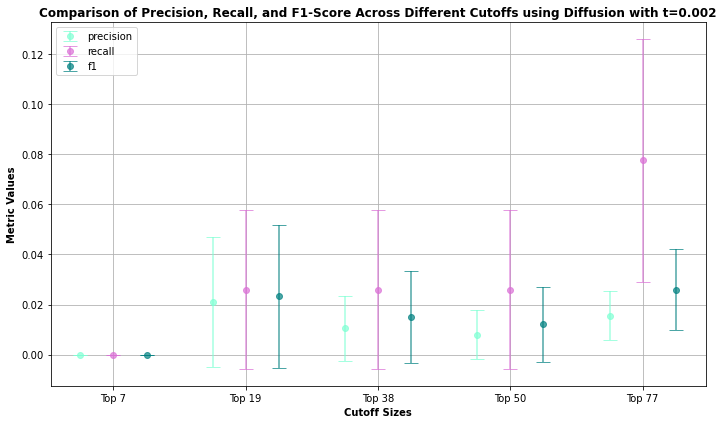

In [64]:
metric_colors = {'precision': 'aquamarine', 'recall': 'orchid', 'f1': 'teal'}  
plot_all_metrics(metrics_diff2, sizes, metric_colors, 'Diffusion with t=0.002')

#### t=0.005

In [65]:
diffusion5 = pd.read_csv('output_diffusion/T5.csv')
diffusion5 = diffusion5.rename(columns={'diffusion_output_rank':'diffusion_output_0_rank'})
diffusion5

,diffusion_input,diffusion_output_1_heat,diffusion_output_1_rank,diffusion_output_2_heat,diffusion_output_2_rank,diffusion_output_3_heat,diffusion_output_3_rank,diffusion_output_4_heat,diffusion_output_4_rank,diffusion_output_heat,diffusion_output_0_rank,name,selected,shared name
0,0.0,2.159184e-09,19815,2.331621e-09,19815,2.229141e-09,19815,1.972862e-09,19814,2.102817e-09,19814,OR2T12,False,OR2T12
1,0.0,9.141369e-08,19790,7.611099e-08,19795,8.325160e-08,19790,6.601718e-08,19790,6.663973e-08,19791,POTEH,False,POTEH
2,0.0,1.731541e-07,19771,1.807434e-07,19769,1.759705e-07,19766,8.740566e-08,19788,1.316652e-07,19777,SPDYE3,False,SPDYE3
3,0.0,7.648051e-08,19792,1.044007e-05,18833,1.043867e-05,18582,1.043103e-05,18305,1.037956e-05,18411,VNN3,False,VNN3
4,0.0,6.836378e-06,19090,6.798924e-06,19198,6.986732e-06,19193,3.447150e-06,19224,6.258345e-06,19113,LOC100996747,False,LOC100996747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19811,0.0,2.164398e-04,10174,2.534391e-04,9791,2.561422e-04,9553,2.151642e-04,9659,2.301734e-04,9566,MAP3K8,False,MAP3K8
19812,0.0,5.600821e-04,6483,5.540452e-04,6753,5.483522e-04,6613,3.525101e-04,7489,4.769424e-04,6500,MAP4K2,False,MAP4K2
19813,0.0,5.877187e-03,387,8.094556e-03,199,6.932106e-03,238,5.574897e-03,418,6.543471e-03,283,MAPK8,False,MAPK8
19814,0.0,1.334898e-03,4243,1.403230e-03,4299,1.392048e-03,4231,1.123383e-03,3801,1.186987e-03,4001,SPAG9,False,SPAG9


In [66]:
precisions, recalls, f1_scores = [], [], []
top_n = 100

for i in range(5):
    column_name = f'diffusion_output_{i}_rank'  
    all_genes = diffusion5.sort_values(by=column_name)['name'].to_list()
    train_set_file = f'train_sets/train_set_fold_{i+1}.txt'
    with open(train_set_file, 'r') as file:
        train_set = {line.strip() for line in file}

    top_genes = [gene for gene in all_genes if gene not in train_set][:top_n]
    len(top_genes)
    probe_set_file = f'probe_sets/probe_set_fold_{i+1}.txt'  
    with open(probe_set_file, 'r') as file:
        probe_set = {line.strip() for line in file}
        
    print(f"Probe Set fold {i+1}: ", probe_set)
    
    true_positives = set(top_genes).intersection(probe_set)
    print(f"True positives fold {i+1}: ", true_positives)
    print(" ")

    precision = len(true_positives) / len(top_genes) if top_genes else 0
    recall = len(true_positives) / len(probe_set) if probe_set else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

Probe Set fold 1:  {'ACTA2', 'IL13', 'CALCA', 'MTOR', 'CCL11', 'MMP2', 'CCL2', 'FGF7', 'DSP', 'IL5', 'SKIL', 'MIR200C', 'SOD1', 'MMP9', 'SPP1', 'CCL3'}
True positives fold 1:  {'CCL11', 'CCL2'}
 
Probe Set fold 2:  {'TGFB1', 'AREG', 'ABCA3', 'SMAD7', 'TGFA', 'TIMP1', 'EDN1', 'PDGFB', 'CXCL2', 'NFE2L2', 'IL12B', 'MIR378A', 'CCL5', 'SERPINA1', 'CEBPB', 'CYSLTR2'}
True positives fold 2:  {'CCL5'}
 
Probe Set fold 3:  {'CXCL8', 'MIR140', 'IL6', 'TNF', 'GREM1', 'CAT', 'ADIPOQ', 'FGF1', 'PTX3', 'IL1B', 'CFD', 'EGF', 'CSF2', 'CMA1', 'IGF1'}
True positives fold 3:  {'CXCL8'}
 
Probe Set fold 4:  {'PDGFA', 'BMP7', 'CCR3', 'AGT', 'LAMB1', 'ELN', 'STAT3', 'MIR326', 'MIR122', 'MIR29C', 'HMOX1', 'FAM13A', 'HGF', 'CCL4', 'COL3A1'}
True positives fold 4:  {'STAT3', 'CCR3'}
 
Probe Set fold 5:  {'CSF3', 'IL1RN', 'PARP1', 'IL4', 'MIR26B', 'MECP2', 'FGF2', 'STAT6', 'CEBPA', 'MIR30A', 'CCR2', 'SOD3', 'FN1', 'HMGB1', 'FYN'}
True positives fold 5:  set()
 


In [67]:
overall_avg_precision_diff5 = np.mean(precisions)
overall_sd_precision_diff5 = np.std(precisions)

overall_avg_recall_diff5 = np.mean(recalls)
overall_sd_recall_diff5 = np.std(recalls)

overall_avg_f1_diff5 = np.mean(f1_scores)
overall_sd_f1_diff5 = np.std(f1_scores)

print(f"Overall Precision (average ± SD) using Diffusion with t=0.005: {overall_avg_precision_diff5:.4f} ± {overall_sd_precision_diff5:.4f}")
print(f"Overall Recall (average ± SD) using Diffusion with t=0.005: {overall_avg_recall_diff5:.4f} ± {overall_sd_recall_diff5:.4f}")
print(f"Overall F1-Score (average ± SD) Diffusion with t=0.005: {overall_avg_f1_diff5:.4f} ± {overall_sd_f1_diff5:.4f}")

Overall Precision (average ± SD) using Diffusion with t=0.005: 0.0120 ± 0.0075
Overall Recall (average ± SD) using Diffusion with t=0.005: 0.0775 ± 0.0484
Overall F1-Score (average ± SD) Diffusion with t=0.005: 0.0208 ± 0.0130


In [68]:
n = disease_network.number_of_nodes()
sizes = [n // 10, n // 4, n // 2, 50, n] 
cutoffs = [int(0.1 * n), int(0.25 * n), int(0.5 * n), 50, n]
metrics_diff = {size: {'precision': [], 'recall': [], 'f1': []} for size in sizes}

for n_fold in range(1, 6):
    
    probe_set_file = f"probe_sets/probe_set_fold_{n_fold}.txt"
    with open(probe_set_file, "r") as file:
        probe_set = {line.strip() for line in file}

    train_set_file = f"train_sets/train_set_fold_{n_fold}.txt"
    with open(train_set_file, "r") as file:
        train_set = {line.strip() for line in file}

    column_name = f'diffusion_output_{n_fold-1}_rank'
    all_genes = diffusion5.sort_values(by=column_name)['name'].to_list()
    top_genes = [gene for gene in all_genes if gene not in train_set]

    for i, size in enumerate(sizes):
        cutoff = cutoffs[i]
        selected_genes = set(top_genes[:cutoff])
        true_positives = selected_genes.intersection(probe_set)

        precision = len(true_positives) / len(selected_genes) if selected_genes else 0
        recall = len(true_positives) / len(probe_set) if probe_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

        metrics_diff[size]['precision'].append(precision)
        metrics_diff[size]['recall'].append(recall)
        metrics_diff[size]['f1'].append(f1)
        
for size in sizes:
    avg_diff_precision = np.mean(metrics_diff[size]['precision'])
    sd_diff_precision = np.std(metrics_diff[size]['precision'])
    
    avg_diff_recall = np.mean(metrics_diff[size]['recall'])
    sd_diff_recall = np.std(metrics_diff[size]['recall'])
    
    avg_diff_f1 = np.mean(metrics_diff[size]['f1'])
    sd_diff_f1 = np.std(metrics_diff[size]['f1'])
    
    print(f"Top_{size} - Precision (average ± SD) using Diffusion with t=0.005: {avg_diff_precision:.4f} ± {sd_diff_precision:.4f}")
    print(f"Top_{size} - Recall (average ± SD) using Diffusion with t=0.005: {avg_diff_recall:.4f} ± {sd_diff_recall:.4f}")
    print(f"Top_{size} - F1-Score (average ± SD) using Diffusion with t=0.005: {avg_diff_f1:.4f} ± {sd_diff_f1:.4f}")
    print("")


Top_7 - Precision (average ± SD) using Diffusion with t=0.005: 0.0857 ± 0.1143
Top_7 - Recall (average ± SD) using Diffusion with t=0.005: 0.0375 ± 0.0500
Top_7 - F1-Score (average ± SD) using Diffusion with t=0.005: 0.0522 ± 0.0696

Top_19 - Precision (average ± SD) using Diffusion with t=0.005: 0.0421 ± 0.0394
Top_19 - Recall (average ± SD) using Diffusion with t=0.005: 0.0508 ± 0.0470
Top_19 - F1-Score (average ± SD) using Diffusion with t=0.005: 0.0461 ± 0.0429

Top_38 - Precision (average ± SD) using Diffusion with t=0.005: 0.0211 ± 0.0197
Top_38 - Recall (average ± SD) using Diffusion with t=0.005: 0.0508 ± 0.0470
Top_38 - F1-Score (average ± SD) using Diffusion with t=0.005: 0.0298 ± 0.0278

Top_50 - Precision (average ± SD) using Diffusion with t=0.005: 0.0200 ± 0.0179
Top_50 - Recall (average ± SD) using Diffusion with t=0.005: 0.0642 ± 0.0578
Top_50 - F1-Score (average ± SD) using Diffusion with t=0.005: 0.0305 ± 0.0273

Top_77 - Precision (average ± SD) using Diffusion with 

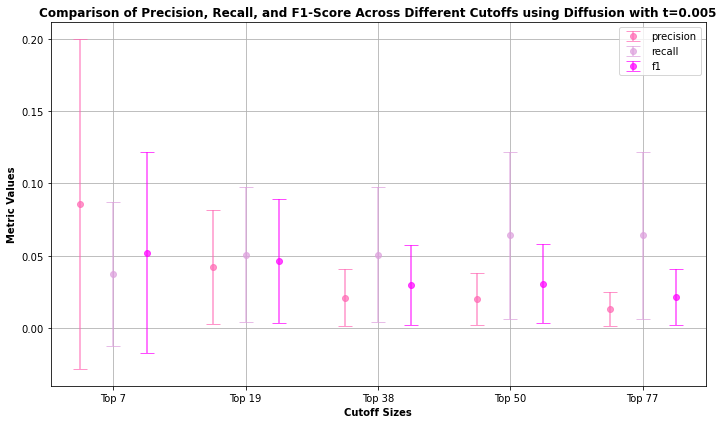

In [69]:
metric_colors = {'precision': 'hotpink', 'recall': 'plum'  , 'f1': 'magenta'}  
plot_all_metrics(metrics_diff, sizes, metric_colors, 'Diffusion with t=0.005')

#### t=0.01

In [70]:
diffusion1 = pd.read_csv('output_diffusion/T1.csv')
diffusion1 = diffusion1.rename(columns={'diffusion_output_rank':'diffusion_output_0_rank'})
diffusion1

,diffusion_input,diffusion_output_1_heat,diffusion_output_1_rank,diffusion_output_2_heat,diffusion_output_2_rank,diffusion_output_3_heat,diffusion_output_3_rank,diffusion_output_4_heat,diffusion_output_4_rank,diffusion_output_heat,diffusion_output_0_rank,name,selected,shared name
0,0.0,2.197859e-08,19815,2.385496e-08,19814,2.282010e-08,19815,2.091888e-08,19814,2.180951e-08,19814,OR2T12,False,OR2T12
1,0.0,4.865221e-07,19790,3.941565e-07,19795,4.537891e-07,19791,3.877796e-07,19790,3.846514e-07,19792,POTEH,False,POTEH
2,0.0,8.528711e-07,19777,8.959961e-07,19778,8.752254e-07,19774,5.250742e-07,19788,6.610979e-07,19782,SPDYE3,False,SPDYE3
3,0.0,4.848334e-07,19791,3.534546e-05,18110,3.533082e-05,18030,3.529858e-05,17863,3.498370e-05,17982,VNN3,False,VNN3
4,0.0,2.084817e-05,18897,2.083100e-05,19179,2.132575e-05,18921,1.426768e-05,19235,1.874593e-05,19093,LOC100996747,False,LOC100996747
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19811,0.0,4.802597e-04,10671,5.689842e-04,10208,5.772809e-04,9950,4.939308e-04,10207,5.205780e-04,10023,MAP3K8,False,MAP3K8
19812,0.0,1.265228e-03,6258,1.266314e-03,6540,1.246334e-03,6441,9.309917e-04,7106,1.099517e-03,6387,MAP4K2,False,MAP4K2
19813,0.0,5.380148e-03,885,7.370487e-03,426,6.796008e-03,478,4.934427e-03,1121,6.371513e-03,582,MAPK8,False,MAPK8
19814,0.0,2.179135e-03,4028,2.272744e-03,4113,2.269293e-03,4060,1.972111e-03,3874,2.007406e-03,3735,SPAG9,False,SPAG9


In [71]:
precisions, recalls, f1_scores = [], [], []
top_n = 100

for i in range(5):
    column_name = f'diffusion_output_{i}_rank'  
    all_genes = diffusion1.sort_values(by=column_name)['name'].to_list()
    train_set_file = f'train_sets/train_set_fold_{i+1}.txt'
    with open(train_set_file, 'r') as file:
        train_set = {line.strip() for line in file}

    top_genes = [gene for gene in all_genes if gene not in train_set][:top_n]
    
    probe_set_file = f'probe_sets/probe_set_fold_{i+1}.txt'  
    with open(probe_set_file, 'r') as file:
        probe_set = {line.strip() for line in file}
    print(f"Probe Set fold {i+1}: ", probe_set)
    
    true_positives = set(top_genes).intersection(probe_set)
    print(f"True positives fold {i+1}: ", true_positives)
    print("")

    precision = len(true_positives) / len(top_genes) if top_genes else 0
    recall = len(true_positives) / len(probe_set) if probe_set else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

Probe Set fold 1:  {'ACTA2', 'IL13', 'CALCA', 'MTOR', 'CCL11', 'MMP2', 'CCL2', 'FGF7', 'DSP', 'IL5', 'SKIL', 'MIR200C', 'SOD1', 'MMP9', 'SPP1', 'CCL3'}
True positives fold 1:  {'CCL11', 'CCL2', 'MMP9'}

Probe Set fold 2:  {'TGFB1', 'AREG', 'ABCA3', 'SMAD7', 'TGFA', 'TIMP1', 'EDN1', 'PDGFB', 'CXCL2', 'NFE2L2', 'IL12B', 'MIR378A', 'CCL5', 'SERPINA1', 'CEBPB', 'CYSLTR2'}
True positives fold 2:  {'PDGFB', 'CCL5'}

Probe Set fold 3:  {'CXCL8', 'MIR140', 'IL6', 'TNF', 'GREM1', 'CAT', 'ADIPOQ', 'FGF1', 'PTX3', 'IL1B', 'CFD', 'EGF', 'CSF2', 'CMA1', 'IGF1'}
True positives fold 3:  {'CXCL8', 'PTX3'}

Probe Set fold 4:  {'PDGFA', 'BMP7', 'CCR3', 'AGT', 'LAMB1', 'ELN', 'STAT3', 'MIR326', 'MIR122', 'MIR29C', 'HMOX1', 'FAM13A', 'HGF', 'CCL4', 'COL3A1'}
True positives fold 4:  {'CCR3'}

Probe Set fold 5:  {'CSF3', 'IL1RN', 'PARP1', 'IL4', 'MIR26B', 'MECP2', 'FGF2', 'STAT6', 'CEBPA', 'MIR30A', 'CCR2', 'SOD3', 'FN1', 'HMGB1', 'FYN'}
True positives fold 5:  set()



In [72]:
overall_avg_precision_diff1 = np.mean(precisions)
overall_sd_precision_diff1 = np.std(precisions)

overall_avg_recall_diff1 = np.mean(recalls)
overall_sd_recall_diff1 = np.std(recalls)

overall_avg_f1_diff1 = np.mean(f1_scores)
overall_sd_f1_diff1 = np.std(f1_scores)

print(f"Overall Precision (average ± SD) using Diffusion with t=0.001: {overall_avg_precision_diff1:.4f} ± {overall_sd_precision_diff1:.4f}")
print(f"Overall Recall (average ± SD) using Diffusion with t=0.001: {overall_avg_recall_diff1:.4f} ± {overall_sd_recall_diff1:.4f}")
print(f"Overall F1-Score (average ± SD) using Diffusion with t=0.001: {overall_avg_f1_diff1:.4f} ± {overall_sd_f1_diff1:.4f}")

Overall Precision (average ± SD) using Diffusion with t=0.001: 0.0160 ± 0.0102
Overall Recall (average ± SD) using Diffusion with t=0.001: 0.1025 ± 0.0640
Overall F1-Score (average ± SD) using Diffusion with t=0.001: 0.0277 ± 0.0176


In [73]:
n = disease_network.number_of_nodes()
sizes = [n // 10, n // 4, n // 2, 50, n] 
cutoffs = [int(0.1 * n), int(0.25 * n), int(0.5 * n), 50, n]
metrics_diff = {size: {'precision': [], 'recall': [], 'f1': []} for size in sizes}

for n_fold in range(1, 6):
    
    probe_set_file = f"probe_sets/probe_set_fold_{n_fold}.txt"
    with open(probe_set_file, "r") as file:
        probe_set = {line.strip() for line in file}

    train_set_file = f"train_sets/train_set_fold_{n_fold}.txt"
    with open(train_set_file, "r") as file:
        train_set = {line.strip() for line in file}

    column_name = f'diffusion_output_{n_fold-1}_rank'
    all_genes = diffusion1.sort_values(by=column_name)['name'].to_list()
    top_genes = [gene for gene in all_genes if gene not in train_set]

    for i, size in enumerate(sizes):
        cutoff = cutoffs[i]
        selected_genes = set(top_genes[:cutoff])
        true_positives = selected_genes.intersection(probe_set)

        precision = len(true_positives) / len(selected_genes) if selected_genes else 0
        recall = len(true_positives) / len(probe_set) if probe_set else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

        metrics_diff[size]['precision'].append(precision)
        metrics_diff[size]['recall'].append(recall)
        metrics_diff[size]['f1'].append(f1)

for size in sizes:
    avg_diff_precision = np.mean(metrics_diff[size]['precision'])
    sd_diff_precision = np.std(metrics_diff[size]['precision'])
    
    avg_diff_recall = np.mean(metrics_diff[size]['recall'])
    sd_diff_recall = np.std(metrics_diff[size]['recall'])
    
    avg_diff_f1 = np.mean(metrics_diff[size]['f1'])
    sd_diff_f1 = np.std(metrics_diff[size]['f1'])
    
    print(f"Top_{size} - Precision (average ± SD) using Diffusion with t=0.001: {avg_diff_precision:.4f} ± {sd_diff_precision:.4f}")
    print(f"Top_{size} - Recall (average ± SD) using Diffusion with t=0.001: {avg_diff_recall:.4f} ± {sd_diff_recall:.4f}")
    print(f"Top_{size} - F1-Score (average ± SD) using Diffusion with t=0.001: {avg_diff_f1:.4f} ± {sd_diff_f1:.4f}")
    print("")

Top_7 - Precision (average ± SD) using Diffusion with t=0.001: 0.0857 ± 0.1143
Top_7 - Recall (average ± SD) using Diffusion with t=0.001: 0.0375 ± 0.0500
Top_7 - F1-Score (average ± SD) using Diffusion with t=0.001: 0.0522 ± 0.0696

Top_19 - Precision (average ± SD) using Diffusion with t=0.001: 0.0421 ± 0.0394
Top_19 - Recall (average ± SD) using Diffusion with t=0.001: 0.0508 ± 0.0470
Top_19 - F1-Score (average ± SD) using Diffusion with t=0.001: 0.0461 ± 0.0429

Top_38 - Precision (average ± SD) using Diffusion with t=0.001: 0.0263 ± 0.0166
Top_38 - Recall (average ± SD) using Diffusion with t=0.001: 0.0642 ± 0.0396
Top_38 - F1-Score (average ± SD) using Diffusion with t=0.001: 0.0373 ± 0.0234

Top_50 - Precision (average ± SD) using Diffusion with t=0.001: 0.0240 ± 0.0150
Top_50 - Recall (average ± SD) using Diffusion with t=0.001: 0.0775 ± 0.0484
Top_50 - F1-Score (average ± SD) using Diffusion with t=0.001: 0.0366 ± 0.0229

Top_77 - Precision (average ± SD) using Diffusion with 

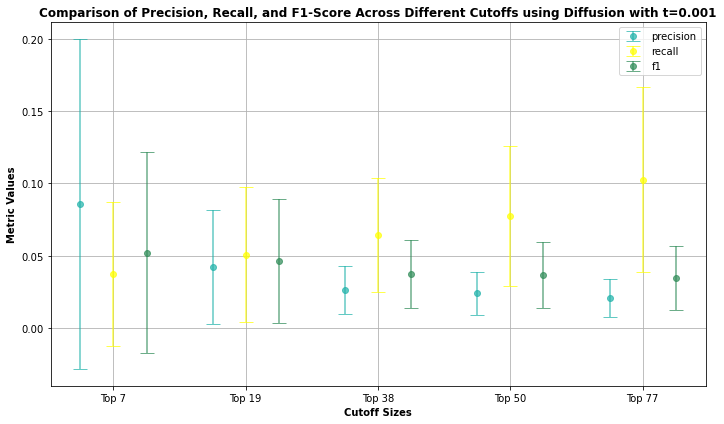

In [74]:
metric_colors = {'precision': 'lightseagreen', 'recall': 'yellow'  , 'f1': 'seagreen'}  
plot_all_metrics(metrics_diff, sizes, metric_colors, 'Diffusion with t=0.001')

### 2.6 Algorithms Performance Evaluation

In [75]:
comparison_table = {
    'Algorithms' : ['DIAMOnD', 'DiaBLE', 'Diffusion t = 0.002', 'Diffusion  t = 0.005', 'Diffusion t = 0.001'],
    'Average Precision': [overall_avg_diamond_precision, overall_avg_diable_precision, overall_avg_precision_diff2, overall_avg_precision_diff5, overall_avg_precision_diff1],
    'Precision Standard Deviation': [overall_sd_diamond_precision, overall_sd_diable_precision, overall_sd_precision_diff2, overall_sd_precision_diff5, overall_sd_precision_diff1],
    'Average Recall': [overall_avg_diamond_recall, overall_avg_diable_recall, overall_avg_recall_diff2, overall_avg_recall_diff5, overall_avg_recall_diff1],
    'Recall Standard Deviation': [overall_sd_diamond_recall, overall_sd_diable_recall, overall_sd_recall_diff2, overall_sd_recall_diff5, overall_sd_recall_diff1],
    'Average F1 Score': [overall_avg_diamond_f1, overall_avg_diable_f1, overall_avg_f1_diff2, overall_avg_f1_diff5, overall_avg_f1_diff1],
    'F1 Score Standard Deviation' : [overall_sd_diamond_f1, overall_sd_diable_f1, overall_sd_f1_diff2, overall_sd_f1_diff5, overall_sd_f1_diff1]
}

In [76]:
df_comparison = pd.DataFrame(comparison_table)
df_comparison = df_comparison.style.highlight_max(color = 'pink', subset = "Average F1 Score")
df_comparison

,Algorithms,Average Precision,Precision Standard Deviation,Average Recall,Recall Standard Deviation,Average F1 Score,F1 Score Standard Deviation
0,DIAMOnD,0.024000,0.013565,0.154167,0.085554,0.041529,0.023410
1,DiaBLE,0.024000,0.013565,0.154167,0.085554,0.041529,0.023410
2,Diffusion t = 0.002,0.012000,0.007483,0.077500,0.048419,0.020780,0.012959
3,Diffusion t = 0.005,0.012000,0.007483,0.077500,0.048419,0.020780,0.012959
4,Diffusion t = 0.001,0.016000,0.010198,0.102500,0.063988,0.027676,0.017589


## 3. Putative Disease Genes Identification

In [131]:
# select the best performing algorithm -> DiaBLE
# obtain a list of 100 putative disease genes
get_ipython().run_line_magic('run', f'algorithms/DiaBLE.py bio.txt seeds.txt 100 final_output.txt')


 results have been saved to 'final_output.txt' 



In [140]:
final_output = 'final_output.txt'
with open(final_output, "r") as file:
    top_genes = [line.strip().split()[1] for line in file if line.strip() and not line.startswith('#')]

In [141]:
print("List of top 100 genes: ", top_genes, end = ' ')

List of top 100 genes:  ['PF4', 'CXCL12', 'CXCL6', 'CCL8', 'CXCL10', 'CCL13', 'CXCL11', 'CCL26', 'XCL1', 'CXCL17', 'CCL28', 'CXCL14', 'CCL21', 'CXCL9', 'PPBP', 'XCL2', 'PF4V1', 'CCL25', 'CCL24', 'CCL20', 'VCAN', 'CCL17', 'CXCL5', 'CXCL3', 'CXCL1', 'CCL27', 'CXCR3', 'CCL7', 'THBS1', 'COL2A1', 'COL4A1', 'BGN', 'COL18A1', 'COL6A1', 'MAG', 'COL5A1', 'C1QTNF1', 'LAIR2', 'COLGALT2', 'COL4A2', 'COL9A1', 'COL8A2', 'COL12A1', 'C1QC', 'COL6A2', 'C1QTNF9', 'COL14A1', 'C1QTNF9B', 'C1QTNF2', 'PLOD3', 'COLQ', 'COL21A1', 'PLOD1', 'COL4A6', 'COL1A1', 'COLEC12', 'COL13A1', 'DCN', 'LEPREL2', 'C1QB', 'PLOD2', 'COLEC11', 'C1QA', 'COLEC10', 'VHL', 'P3H4', 'SPARC', 'COLGALT1', 'TGM2', 'ITGAV', 'COL23A1', 'COL7A1', 'OS9', 'PRELP', 'FBXO2', 'SCARA3', 'TMEM106B', 'HSPG2', 'IL5RA', 'LAMA5', 'NID2', 'TMEM25', 'LAMA1', 'FBLN2', 'NID1', 'HSPA5', 'LAMC1', 'CRP', 'LY86', 'LAMB2', 'NCR3', 'PRG2', 'LAMC3', 'GUSB', 'SDF2L1', 'C1QL4', 'TAZ', 'POGLUT1', 'LYZL2', 'CNTNAP3'] 

In [142]:
with open('putative_seed_genes_100.txt', 'w') as file: 
    for putative_gene in top_genes:
        file.write(putative_gene)
        file.write("\n")  

In [143]:
tot_genes = list(set(seed_genes_list + top_genes))
print("Number of total genes: ", len(tot_genes))
print("List of total genes:" , tot_genes, end = ' ')

Number of total genes:  177
List of total genes: ['TMEM25', 'COLGALT1', 'POGLUT1', 'MIR200C', 'SMAD7', 'EGF', 'PTX3', 'MIR29C', 'CXCL12', 'FBXO2', 'PRG2', 'IL1RN', 'CCL27', 'CXCL3', 'C1QB', 'CXCL5', 'PLOD1', 'CCL24', 'LAMB2', 'COL4A6', 'VHL', 'BMP7', 'COL5A1', 'AREG', 'COLQ', 'CXCR3', 'HSPA5', 'DSP', 'CCL3', 'CCL5', 'CCL17', 'PDGFB', 'CXCL10', 'CXCL9', 'MIR326', 'CXCL14', 'IGF1', 'C1QTNF1', 'COLEC12', 'NID1', 'COL6A2', 'CALCA', 'C1QTNF9', 'NCR3', 'LAMA5', 'ITGAV', 'SPARC', 'HSPG2', 'LAMA1', 'IL5RA', 'COL9A1', 'SPP1', 'LAIR2', 'CXCL1', 'CCL2', 'IL1B', 'IL4', 'MIR140', 'FN1', 'CSF3', 'CCL13', 'XCL2', 'CCL4', 'COL1A1', 'LAMC1', 'C1QTNF2', 'STAT6', 'MAG', 'FBLN2', 'TNF', 'XCL1', 'CCL26', 'COLEC10', 'COL23A1', 'LYZL2', 'IL13', 'HGF', 'PRELP', 'C1QL4', 'CSF2', 'LEPREL2', 'CEBPB', 'BGN', 'MIR26B', 'SKIL', 'C1QC', 'CRP', 'SDF2L1', 'AGT', 'MECP2', 'PPBP', 'LAMC3', 'CCR3', 'ELN', 'CCL11', 'COLGALT2', 'CXCL2', 'CMA1', 'DCN', 'GREM1', 'TAZ', 'COL2A1', 'NFE2L2', 'FYN', 'CXCL17', 'CEBPA', 'TGFA', 'C

In [144]:
putative_and_seeds = LCC_bio.subgraph(tot_genes)

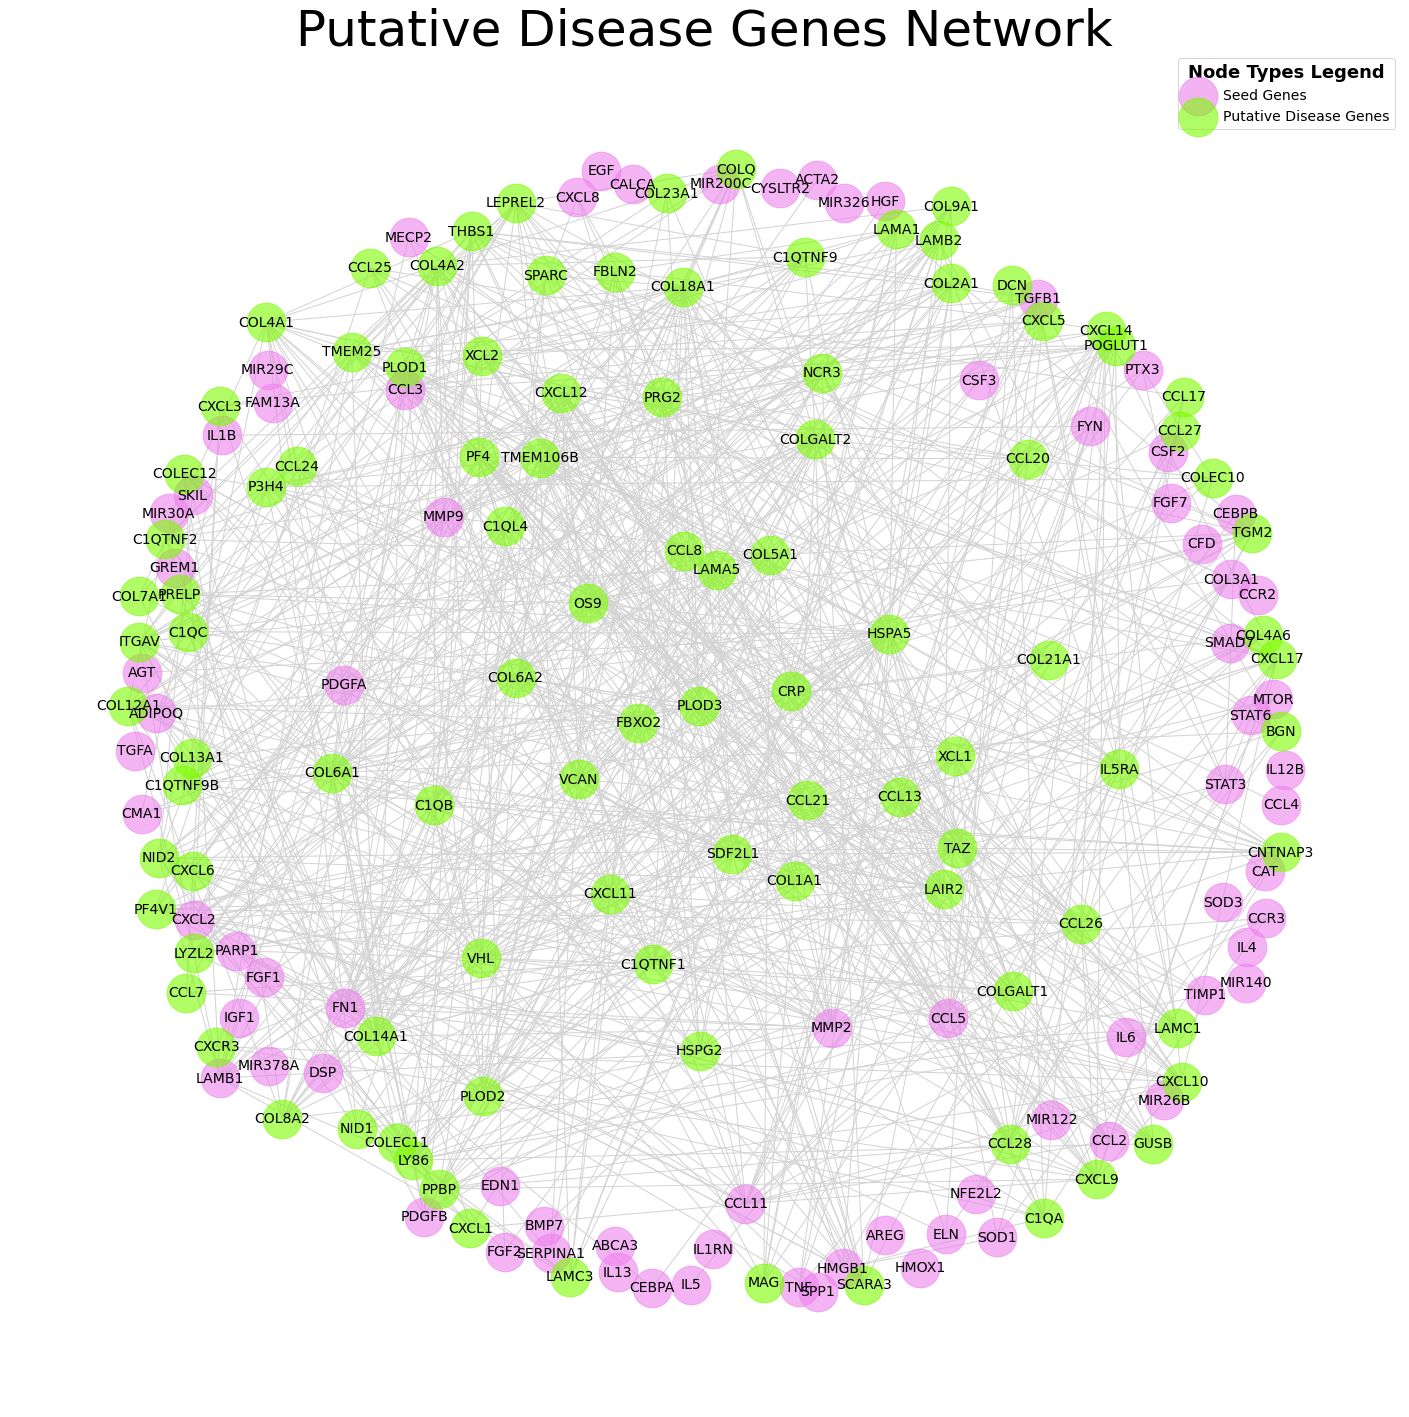

In [174]:
plt.figure(figsize=(25, 25))
pos = nx.spring_layout(putative_and_seeds, k= 1.7) 

nx.draw_networkx_nodes(putative_and_seeds, pos, nodelist=seed_genes_list, node_size=1500, node_color='violet',alpha=0.6, label='Seed Genes')
nx.draw_networkx_nodes(putative_and_seeds, pos, nodelist=top_genes, node_size=1500, node_color='lawngreen', alpha=0.6, label='Putative Disease Genes')

nx.draw_networkx_edges(putative_and_seeds, pos, edge_color='lightgray')
nx.draw_networkx_labels(putative_and_seeds, pos, font_size=14)
#plt.savefig('graph.png', format='png', dpi=500)

legend = plt.legend(loc='upper right', fontsize=14)
legend.set_title("Node Types Legend", prop={'weight':'bold', 'size':'18'})

plt.title("Putative Disease Genes Network", fontsize=50)
plt.axis("off")
plt.show()

## 4. Drug repurposing

In [187]:
drugs = pd.read_csv('drugs.tsv', delimiter='\t')

In [188]:
duplicates = drugs['drug'].duplicated()
drugs['drug'][duplicates]

18    ELDELUMAB
Name: drug, dtype: object

In [190]:
drugs = drugs[drugs['regulatory approval'] =='Approved']
drugs

,gene,drug,regulatory approval,indication,interaction score
1,CXCL12,CHLORAMBUCIL,Approved,NaN,1.340456
3,CXCL12,VINCRISTINE,Approved,antineoplastic agent,0.207676
4,CXCL12,RITUXIMAB,Approved,antineoplastic agent,0.983001
5,CXCL12,FLUDARABINE,Approved,antineoplastic agent,0.446819
6,CXCL12,ALEMTUZUMAB,Approved,antineoplastic agent,4.915004
7,CXCL12,CYCLOPHOSPHAMIDE ANHYDROUS,Approved,NaN,0.204792
8,CXCL12,PREDNISONE,Approved,"corticosteroid,antiinflammatory agent",0.351072
16,CCL21,TINZAPARIN SODIUM,Approved,"for treatment of cystic fibrosis,for treatment...",0.433677
19,CXCL10,ATROPINE,Approved,nerve agent antidote,0.630803
21,CXCL10,TESTOSTERONE,Approved,"for treatment of female sexual dysfunction,hor...",0.182601


In [191]:
drugs['drug'].nunique()

19

In [193]:
drug_gene_counts = drugs.groupby('drug')['gene'].nunique()

drug_rankings = drug_gene_counts.sort_values(ascending=False)

drug_rankings_df = drug_rankings.reset_index()
drug_rankings_df.columns = ['Drug', 'Unique_Genes_Count']
drug_rankings_df

,Drug,Unique_Genes_Count
0,ALEMTUZUMAB,1
1,PEGINTERFERON ALFA-2B,1
2,VINCRISTINE,1
3,TINZAPARIN SODIUM,1
4,TESTOSTERONE,1
5,STAVUDINE,1
6,RITUXIMAB,1
7,RITONAVIR,1
8,PREDNISONE,1
9,PEGINTERFERON ALFA-2A,1


In [195]:
drug_gene_info = drugs.groupby('drug').agg({
    'gene': ['nunique', lambda x: list(x.unique())]
})


drug_gene_info.columns = ['Unique_Genes_Count', 'Associated_Genes']


drug_gene_info = drug_gene_info.reset_index()


drug_gene_info = drug_gene_info.sort_values(by='Unique_Genes_Count', ascending=False)
drug_gene_info['Associated_Genes'] = drug_gene_info['Associated_Genes'].apply(lambda x: ', '.join(x))
drug_gene_info = drug_gene_info.reset_index(drop=True)
drug_gene_info.insert(0, 'Ranking', range(1, 1 + len(drug_gene_info)))
drug_gene_info

,Ranking,drug,Unique_Genes_Count,Associated_Genes
0,1,ALEMTUZUMAB,1,CXCL12
1,2,PEGINTERFERON ALFA-2B,1,CXCL10
2,3,VINCRISTINE,1,CXCL12
3,4,TINZAPARIN SODIUM,1,CCL21
4,5,TESTOSTERONE,1,CXCL10
5,6,STAVUDINE,1,CXCL10
6,7,RITUXIMAB,1,CXCL12
7,8,RITONAVIR,1,CXCL10
8,9,PREDNISONE,1,CXCL12
9,10,PEGINTERFERON ALFA-2A,1,CXCL10


## 5. Clustering (Optional Question)

### 5.1 MCL

In [151]:
matrix = nx.to_scipy_sparse_array(LCC_bio)
inflation_params = [1.8, 1.9, 2.0, 2.1, 2.2, 2.3]

In [152]:
for param in inflation_params:
    result = mc.run_mcl(matrix, inflation = param) #run MCL with inflation parameters
    clusters = mc.get_clusters(result)  

In [153]:
#select communities with a number of nodes between 10 and 1000
MCL_clusters_filtered = [cluster for cluster in clusters if 10 <= len(cluster) <= 1000]
print("Number of filtered clusters: ", len(MCL_clusters_filtered))

Number of filtered clusters:  158


In [154]:
N = len(LCC_bio.nodes())  
K = len([gene for gene in seed_genes_list if gene in bio.nodes()])  
nodes = np.array(LCC_bio.nodes())

#use Bonferroni method to stabilize the threshold and reduce the overall false positive rate
num_tests = len(MCL_clusters_filtered)
p_value_threshold = 0.05
p_value_threshold_bonferroni = p_value_threshold / num_tests 

putative_disease_modules_MCL = []
for i, idx in enumerate(MCL_clusters_filtered):
    cluster = nodes[list(idx)]
    
    #check via hypergeometric test if the comunity is a putative disease module
    n = len(cluster) 
    k = len([gene for gene in seed_genes_list if gene in cluster]) 
    p_value = hypergeom.sf(k-1, N, K, n) 
    
    if p_value <= p_value_threshold_bonferroni: 
        putative_disease_modules_MCL.append({
            'ref_no': i+1,
            'size': n,
            'known_disease_genes': k,
            'genes': list(cluster)  
            })


In [155]:
for module in putative_disease_modules_MCL:
    print(f"Cluster {module['ref_no']}: Size = {module['size']}, Known Disease Genes = {module['known_disease_genes']}")
    print(f"Genes in Cluster (excluding seed genes): {[i for i in module['genes'] if i not in seed_genes_list]}\n")

Cluster 129: Size = 32, Known Disease Genes = 5
Genes in Cluster (excluding seed genes): ['CXCL5', 'CXCL6', 'CXCR3', 'CXCL10', 'PF4', 'CXCL11', 'CCL7', 'PPBP', 'CXCL13', 'CXCL12', 'CCL20', 'CCL8', 'CCL13', 'CCL17', 'CCL21', 'CCL26', 'CXCL14', 'PF4V1', 'ACKR4', 'CCL28', 'XCL1', 'XCL2', 'CCL25', 'CCL27', 'CCL24', 'CXCL17', 'CXCL3']



#### Enrichment analysis for MCL algorithm

In [156]:
with open('putative_disease_genes_MCL.txt', 'w') as file:
    for module in putative_disease_modules_MCL:
        file.write(f"Cluster {module['ref_no']}: Size = {module['size']}, Known Disease Genes = {module['known_disease_genes']}\n")
        genes = [i for i in module['genes'] if i not in seed_genes_list]
        for gene in genes:
            file.write(gene)
            file.write("\n")   
        file.write("\n")

### 5.2 Louvain Algorithm

In [157]:
#run the Louvain algorithm with gamma=1
louvain_communities = nx.community.louvain_communities(LCC_bio, weight='weight', resolution=1.0, seed=42)

In [158]:
#select communities with a number of nodes between 10 and 1000
louvain_communities_filtered = [community for community in louvain_communities if 10 <= len(community) <= 1000]
print("Number of filtered communities: ", len(louvain_communities_filtered))

Number of filtered communities:  1


In [159]:
N = len(LCC_bio.nodes())  
K = len(seed_genes_list)

p_value_threshold = 0.05
putative_disease_modules_louvain = []

for i, community in enumerate(louvain_communities_filtered):
    
    #check via hypergeometric test if the comunity is a putative disease module
    n = len(community)  
    k = len([gene for gene in seed_genes_list if gene in community])  
    p_value = hypergeom.sf(k-1, N, K, n)
    
    if p_value < p_value_threshold:
        putative_disease_modules_louvain.append({
            'ref_no': i+1,
            'size': n,
            'known_disease_genes': k,
            'genes': list(community)  
        })

In [160]:
for module in putative_disease_modules_louvain:
    print(f"Community {module['ref_no']}: Size = {module['size']}, Known Disease Genes = {module['known_disease_genes']}")
    print(f"Genes in Community (excluding seed genes): {[i for i in module['genes'] if i not in seed_genes_list]}\n")

Community 1: Size = 38, Known Disease Genes = 6
Genes in Community (excluding seed genes): ['PPBP', 'GPR85', 'PF4V1', 'CXCL12', 'CXCL11', 'CCL19', 'ACKR1', 'CCL27', 'CXCL3', 'CXCL5', 'CCL24', 'CXCL1', 'CCL21', 'CXCL17', 'CCL20', 'CCL13', 'XCL2', 'CCL8', 'CXCL13', 'ACKR4', 'CXCR3', 'CCL17', 'CCL7', 'CCL28', 'CXCL10', 'CCL25', 'PF4', 'CXCL14', 'XCL1', 'CCL26', 'CCR7', 'CXCL6']



#### Enrichment analysis for Louvain algorithm

In [173]:
with open('putative_disease_genes_Louvain.txt', 'w') as file:
    for module in putative_disease_modules_louvain:
        file.write(f"Community {module['ref_no']}: Size = {module['size']}, Known Disease Genes = {module['known_disease_genes']}\n")
        genes = [i for i in module['genes'] if i not in seed_genes_list]
        for gene in genes:
            file.write(gene)
            file.write("\n")   
        file.write("\n")